### Evaluation

Intended to be copied to ``notebooks/priv``

#### Setting up project root - to enable using our python files

In [2]:
import sys
import os

# Go two levels up to project root
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(project_root)

#### Loading model - take care of input/output dimensions

In [3]:
import os

from trainer.clipping_model import ClipModels, ClippingModel, tf


model = ClippingModel(
    ClipModels.SHALLOWED_UNET,
    clipping_size=512,
    clipping_surplus=128,
    path=os.path.join("..", "..", "models", "shallowed_unet_512_1m_is_street_only"),
    input_third_dimension=2,
    output_third_dimension=1,
)

2026-02-13 06:47:18.356680: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/czlek/Pulpit/semestr 5/studio projektowe 1/CRoadA/env/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Starting from file: ../../models/shallowed_unet_512_1m_is_street_only/1770957853_epoch12_val_loss5.00_model.keras


I0000 00:00:1770961643.926089  852481 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4620 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


#### Prediction for sample training data

city height:  17351
city width:  19900
DEBUG: input.third_dimension_size: 2

row: 0

2026-02-13 06:47:44.456895: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91800


...
row: 1...
row: 2...DEBUG: img.max(): 1.0


Text(0.5, 1.0, 'predicted road (OUTPUT)')

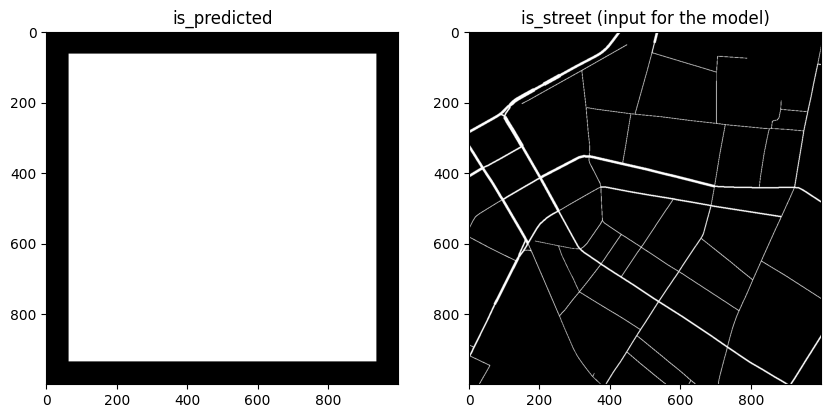

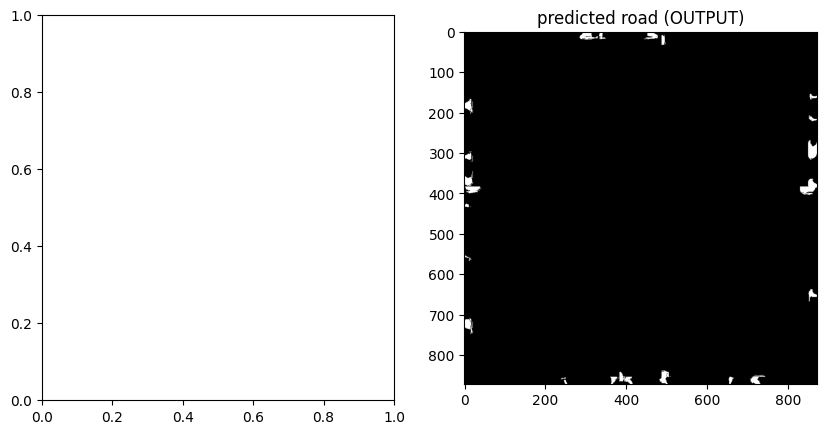

In [4]:
from grid_manager import GridManager
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from trainer.model import PREDICT_GRID_INDICES, TRAINING_GRID_INDICES


grid_manager = GridManager("Bydgoszcz-Polska.city_grid", data_dir="../../grids/with-is-residential")
metadata = grid_manager.get_metadata()
print("city height: ", metadata.rows_number)
print("city width: ", metadata.columns_number)

assert (
    metadata.third_dimension_size == 3
), "You have an outdated version of GridManager. Consider downloading grid files again to get all data..."

fragment_row, fragment_col = 8000, 7000
fragment_height, fragment_width = 1000, 1000

segment_h, segment_w = metadata.segment_h, metadata.segment_w
being_predicted = GridManager(
    f"test_{time.time()}.city_grid",
    fragment_height,
    fragment_width,
    0,
    0,
    metadata.grid_density,
    segment_h,
    segment_w,
    data_dir="grids/evaluation",
    third_dimension_size=model.input_third_dimension,
)
# read_arbitrary_fragment does not take care of memory size - if there are some problems - just use smaller fragment
# Add IS_PREDICTED
tmp = np.zeros((fragment_height, fragment_width, model.input_third_dimension))
tmp[:, :, 1 : model.input_third_dimension] = grid_manager.read_arbitrary_fragment(
    fragment_row, fragment_col, fragment_height, fragment_width
)[:, :, : model.input_third_dimension - 1]

tmp[
    model._clipping_surplus // 2 : -model._clipping_surplus // 2,
    model._clipping_surplus // 2 : -model._clipping_surplus // 2,
    TRAINING_GRID_INDICES.IS_PREDICTED
] = 1

being_predicted.write_arbitrary_fragment(tmp, 0, 0)  # for instance some segment in the middle

debug_imgs = []
debug_outs = []

result = model.predict(being_predicted, debug_imgs, debug_outs)
img = result.read_arbitrary_fragment(
    0, 0, fragment_height - model.get_input_grid_surplus(), fragment_width - model.get_input_grid_surplus()
)[:, :, PREDICT_GRID_INDICES.IS_STREET]

# IMPORTANT - not anymore as it appears
# img = (img > 0.1).astype(np.uint8)  # Threshold the predictions to get binary output

print(f"DEBUG: img.max(): {img.max()}")

# Visualize the prediction
## INPUT
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(tmp[:, :, 0], cmap="gray")  # is_predicted channel
axs[0].set_title("is_predicted")
axs[1].imshow(tmp[:, :, 1], cmap="gray")  # is_street channel
axs[1].set_title("is_street (input for the model)")
## OUTPUT
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[1].imshow(img, cmap="gray")  # predicted road
axs[1].set_title("predicted road (OUTPUT)")

#### [opional] Prediction for validation data

In [ ]:
from grid_manager import GridManager
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from trainer.model import PREDICT_GRID_INDICES, TRAINING_GRID_INDICES


grid_manager = GridManager("Rzeszów-Polska.city_grid", data_dir="../../grids/with-is-residential/validation")
metadata = grid_manager.get_metadata()
print("city height: ", metadata.rows_number)
print("city width: ", metadata.columns_number)

assert (
    metadata.third_dimension_size == 3
), "You have an outdated version of GridManager. Consider downloading grid files again to get all data..."

fragment_row, fragment_col = 8000, 7000
fragment_height, fragment_width = 1000, 1000

segment_h, segment_w = metadata.segment_h, metadata.segment_w
being_predicted = GridManager(
    f"test_{time.time()}.city_grid",
    fragment_height,
    fragment_width,
    0,
    0,
    metadata.grid_density,
    segment_h,
    segment_w,
    data_dir="grids/evaluation",
    third_dimension_size=model.input_third_dimension,
)
# read_arbitrary_fragment does not take care of memory size - if there are some problems - just use smaller fragment
# Add IS_PREDICTED
tmp = np.zeros((fragment_height, fragment_width, model.input_third_dimension))
tmp[:, :, 1 : model.input_third_dimension] = grid_manager.read_arbitrary_fragment(
    fragment_row, fragment_col, fragment_height, fragment_width
)[:, :, : model.input_third_dimension - 1]

tmp[
    model._clipping_surplus // 2 : -model._clipping_surplus // 2,
    model._clipping_surplus // 2 : -model._clipping_surplus // 2,
    TRAINING_GRID_INDICES.IS_PREDICTED
] = 1

being_predicted.write_arbitrary_fragment(tmp, 0, 0)  # for instance some segment in the middle

debug_imgs = []
result = model.predict(being_predicted, debug_imgs)
img = result.read_arbitrary_fragment(
    0, 0, fragment_height - model.get_input_grid_surplus(), fragment_width - model.get_input_grid_surplus()
)[:, :, PREDICT_GRID_INDICES.IS_STREET]

# IMPORTANT - not anymore as it appears
# img = (img > 0.1).astype(np.uint8)  # Threshold the predictions to get binary output

print(f"DEBUG: img.max(): {img.max()}")

# Visualize the prediction
## INPUT
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(tmp[:, :, 0], cmap="gray")  # is_predicted channel
axs[0].set_title("is_predicted")
axs[1].imshow(tmp[:, :, 1], cmap="gray")  # is_street channel
axs[1].set_title("is_street (input for the model)")
## OUTPUT
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[1].imshow(img, cmap="gray")  # predicted road
axs[1].set_title("predicted road (OUTPUT)")

#### Displaying inputs for separate clippings

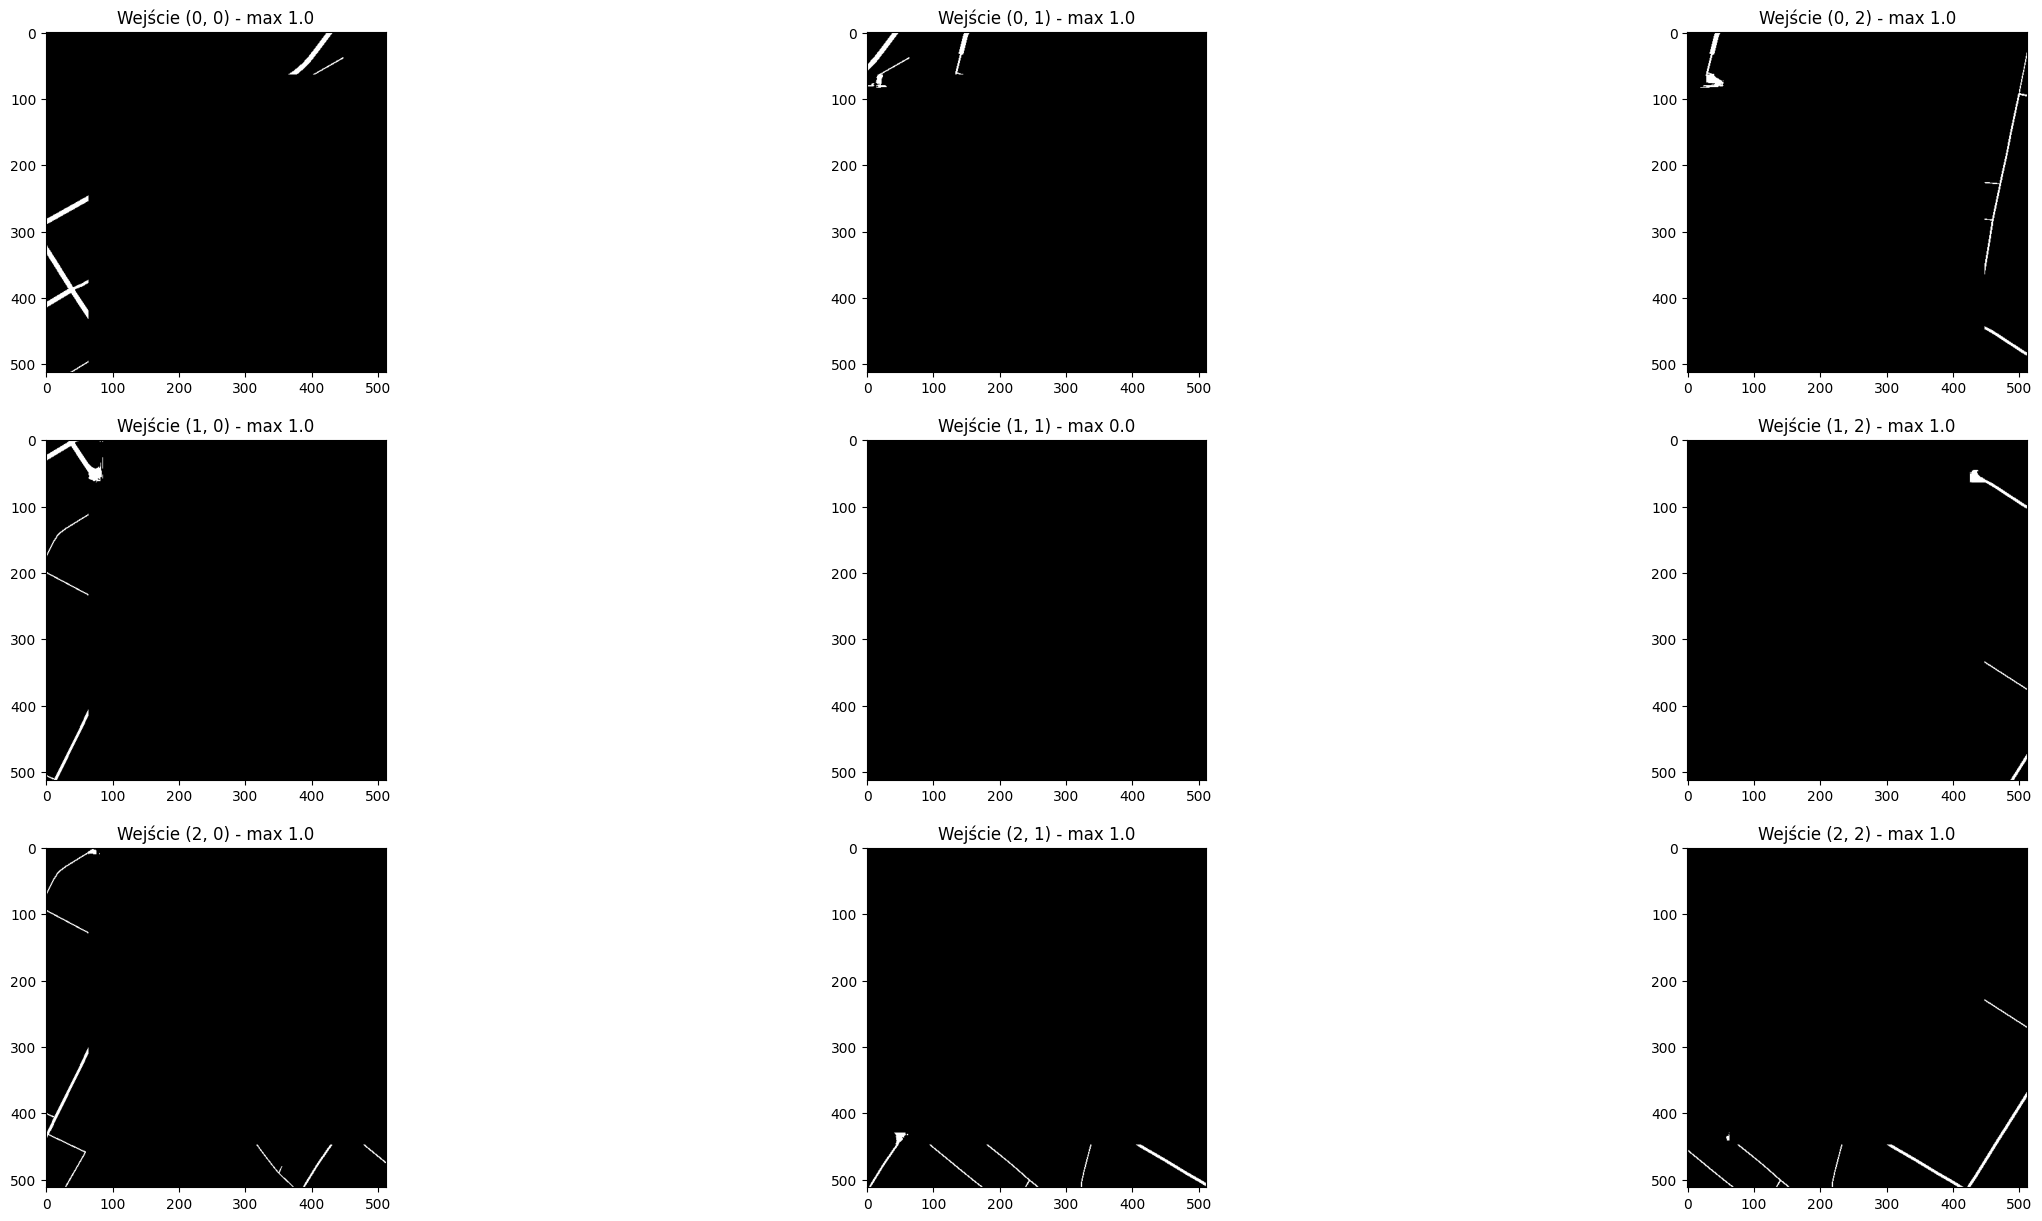

In [6]:
import matplotlib.pyplot as plt
from trainer.model import TRAINING_GRID_INDICES

y_index, x_index = 0, 0
rows_n, cols_n = 3, 3

fig, axs = plt.subplots(max(2, rows_n), max(2, cols_n), figsize=(30, 15))
plt.gray()

for i in range(rows_n):
    for j in range(cols_n):
        ax = axs[i, j]
        img = debug_imgs[y_index + i][x_index + j][:, :, TRAINING_GRID_INDICES.IS_STREET]
        ax.set_title(f"Wejście {(i, j)} - max {img.max()}")
        ax.imshow(img)

#### Displaying outputs of separate clippings

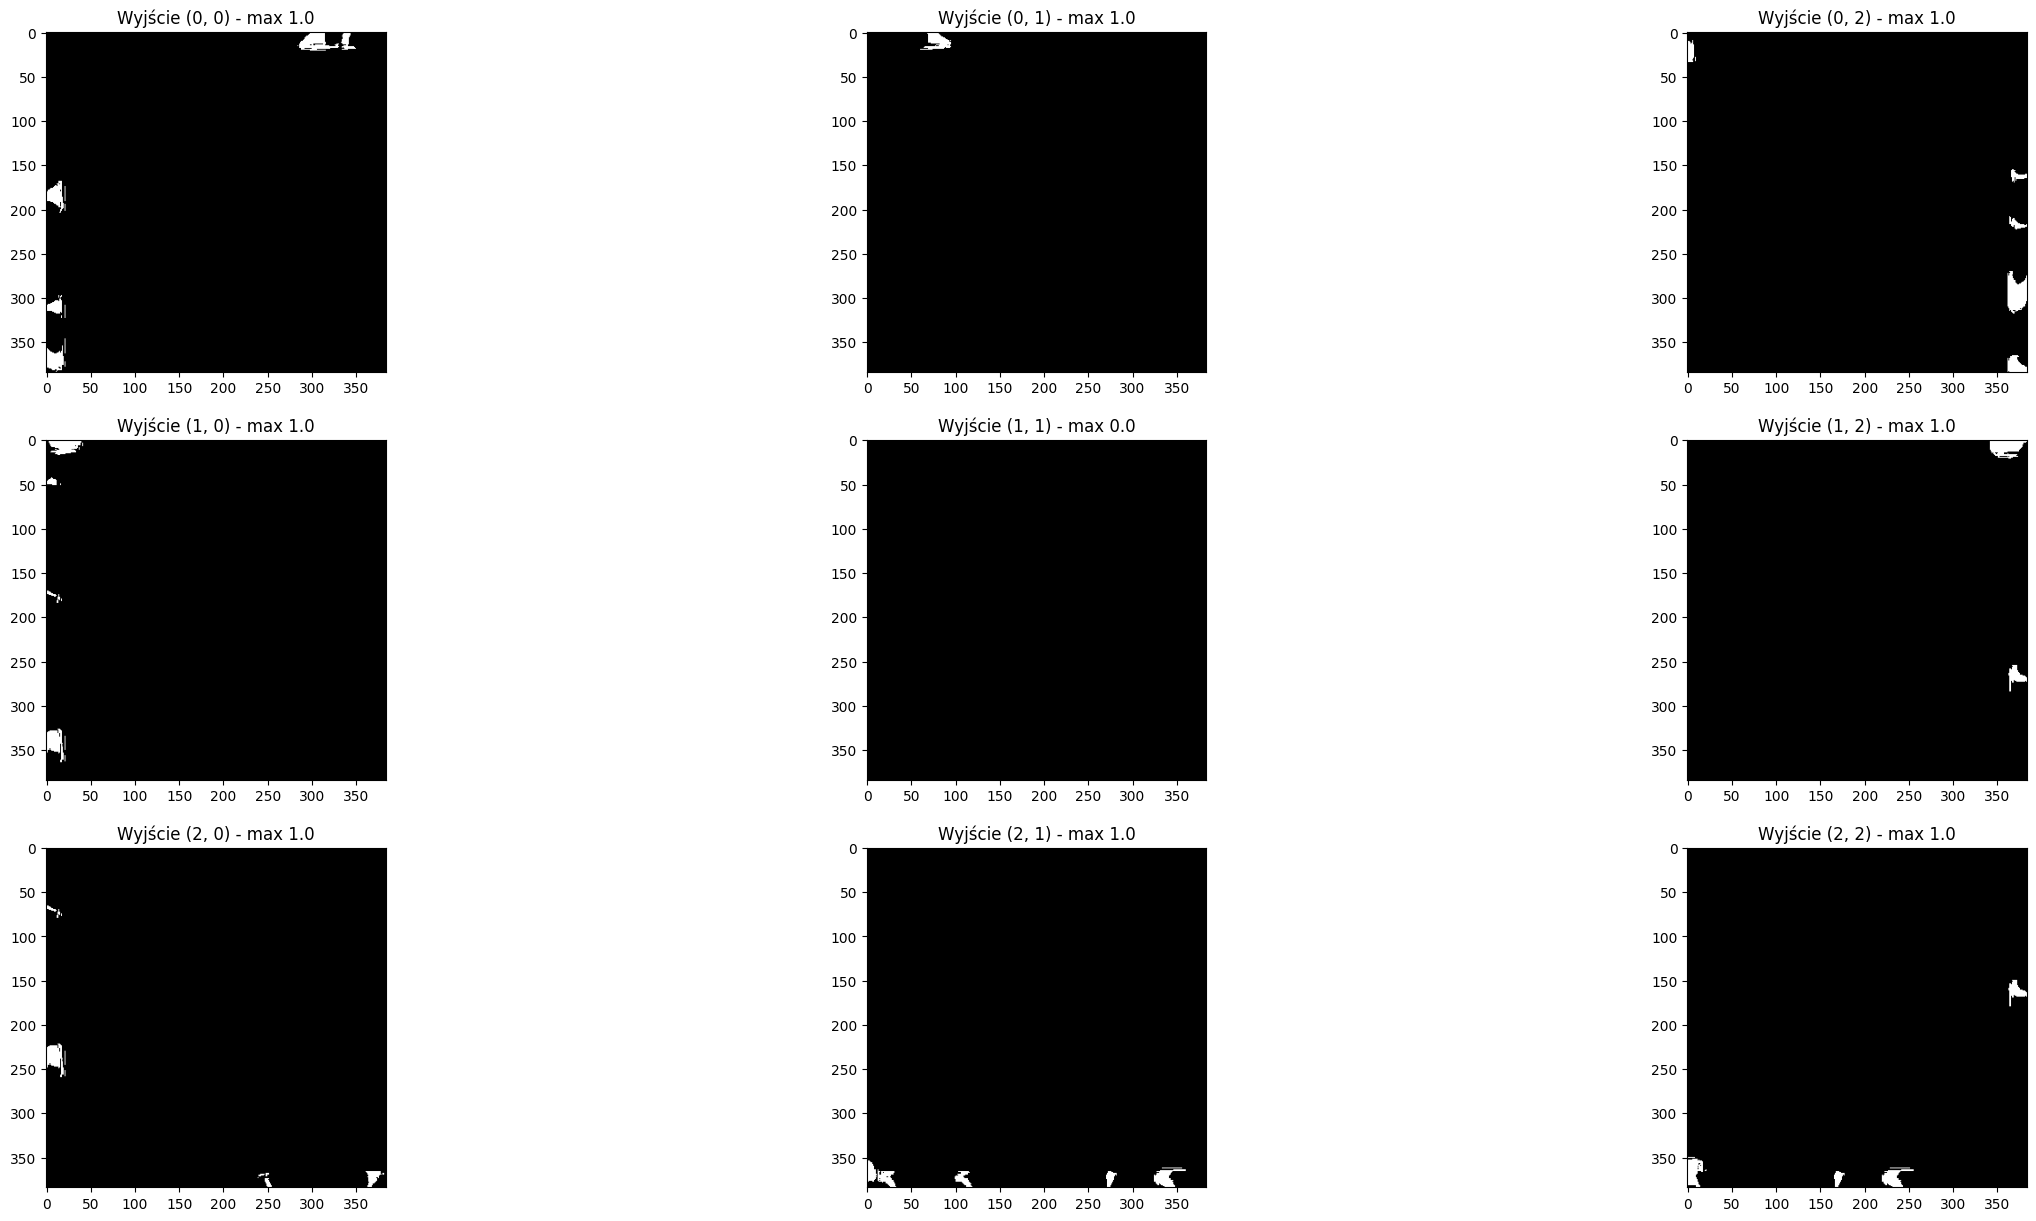

In [7]:
import matplotlib.pyplot as plt
from trainer.model import PREDICT_GRID_INDICES

y_index, x_index = 0, 0
rows_n, cols_n = 3, 3

fig, axs = plt.subplots(max(2, rows_n), max(2, cols_n), figsize=(30, 15))
plt.gray()

for i in range(rows_n):
    for j in range(cols_n):
        ax = axs[i, j]
        img = debug_outs[y_index + i][x_index + j][:, :, PREDICT_GRID_INDICES.IS_STREET]
        ax.set_title(f"Wyjście {(i, j)} - max {img.max()}")
        ax.imshow(img)